# Analizar la medida de un elemento de polarizacion

**Autor**: Jesús del Hoyo

**Fecha**:   05/03/2019

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

Se puede utilizar tanto en transmisión como en reflexión, empleando el fotodiodo como detector.

**Elementos ópticos**:
1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm.
1. Lente colimadora de Thorlabs DG10-600-B.
1. Polarizador 0 LPNIRE100-B.
1. Retardador  0 $\lambda/4$ Thorlabs WPQ10E-850-SP.
1. Polarizador 1 LPNIRE100-B (P1).
1. Retardador  1 $\lambda/4$ Thorlabs WPQ10E-850-SP (R1).
1. Elementos previos a la muestra. Deben estar caracterizados para que el análisis funcione.
1. MUESTRA. 
1. Elementos posteriores a la muestra. Deben estar caracterizados para que el análisis funcione.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R2).
1. Polarizador 2 LPNIRE100-B (P2).
1. Fotodiodo (ver cual).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import pprint
from math import pi
from scipy import optimize

from py_pol.mueller import Mueller
from polaripython.utils import dibujar_2d_fitting, sort_positions, plot_2d_scattered, generate_even_distribution
from polaripython.polarimeter import get_calibration, degrees, polarimeter_experiment, Intensity_Rotating_Elements


3.0.2


## Data loading

Here we choose the file we are going to load.

In [100]:
# Load calibration file
# path_absolute = 'D:\Codigo_UCM\polaripython'
path_absolute = 'D:\codigo\polaripython'
pol_dict=get_calibration(path_absolute + '\polaripython', verbose=True)
Mpol = [pol_dict["Mp1"], pol_dict["Mr1"], pol_dict["Mr2"], pol_dict["Mp2"]]
Ifuente = pol_dict["Ifuente"]
Mbefore = pol_dict['Mbefore']
Mafter = pol_dict['Mafter']

# Load data
path_data = path_absolute + '\medidas_0D\Medidas_2019-03-11'
name = 'Espejo_90deg_2019-03-11.npz'
# name = 'Cubo_CCM1-BSO14_trans_perp_2019-03-11.npz'
# name = 'Cubo_CCM1-BSO14_ref_2019-03-11.npz'
%cd $path_data
data = np.load(name, encoding = 'latin1')
param = data['parametros']
param = np.take(param,0)
angles = data['angulos']
I_to_fit = data['intensidad']
if len(I_to_fit.shape) > 1:
    I_to_fit = I_to_fit[:,0] * I_to_fit[:,1] / pol_dict["normal"]

# Extract some data from the dictionary
globals().update(param)

# Checks
# print(I_to_fit.shape)

Old calibration
Using default (vacuum) Mbefore and Mafter
Calibration loaded succesfully
D:\codigo\polaripython\medidas_0D\Medidas_2019-03-11


**Iluminación**

Poner la fuente al mismo voltaje y corriente que durante la calibración.

T = 25 deg C.

I = 270 mA.

## Analisis

Primero, si es vacio, vamos a comprobar que la intensidad medida y la teorica son proporcionales.

In [101]:
Mbefore = Mueller('Mbefore')
Mbefore.from_matrix(np.identity(4))
Mafter = Mueller('Mbefore')
Mafter.from_matrix(np.identity(4))
# print(Mbefore, Mafter)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

En esta parte analizamos la medida realizada y calculamos la matriz de Mueller.

In [104]:
# Initialize daily_transmission if it does not exist
daily_transmission = 3.05
is_vacuum = False
odd_number_refs = True
tolerance = 1e-3
odd_ref = 0
th_exp = -(180-27.8)*degrees
extra_th = odd_ref*np.array([0, 0, th_exp, th_exp])
# Recompose data
angles_to_fit = np.array(angles)*degrees + extra_th

# Calculate Mueller Matrix
Mcalculated = polarimeter_experiment(M=Mpol, illum=Ifuente, I=I_to_fit, th=angles_to_fit, 
#                                      Mbefore=Mbefore, Mafter=Mafter)
#                                      Mbefore=M_cube_ref, Mafter=Mafter)
                                     Mbefore=M_cube_ref, Mafter=M_cube_trans)
print(Mcalculated)
if is_vacuum:
    daily_transmission = Mcalculated.M[0,0]
    print("Daily transmission: {}".format(daily_transmission))
    Mtarget = np.eye(4)
Mnormalized = Mcalculated / daily_transmission
Mnormalized.name = 'Normalized'
print(Mnormalized)
if is_vacuum:
    error = np.linalg.norm(Mtarget-Mnormalized.M)/16
    print("RMS error: {}".format(error))
# Filter it
Mfiltered = Mnormalized.analysis.filter_physical_conditions(tol=tolerance, verbose=False)
Mfiltered.name = 'Filtered'
# Add the effect of reflection if required
if odd_number_refs:
    Mespejo.from_matrix(np.diag([1, 1, -1, -1]))    
    _, Mr, _ = Mfiltered.analysis.decompose_polar(decomposition='DRP', 
                            verbose=False, give_all=False, tol=tolerance, filter=False)
    _, az, _ = Mr.analysis.retarder(param='az-el')
    Mespejo.rotate(az)
    Mfiltered = Mfiltered * Mespejo
print(Mfiltered)    
    
# Analyze filtered matrix
Md, Mr, Mp = Mfiltered.analysis.decompose_polar(decomposition='DRP', 
                        verbose=True, give_all=False, tol=tolerance, filter=False)
Tmax, Tmin = Mfiltered.parameters.transmissions()
print('The transmissions are: Maximum = {}; Minimum = {}.'.format(Tmax, Tmin))
# # Save the data in the same file
# param = generar_dict_de_param(analysis=True)
# np.savez(filename+'.npz', angulos = angles, parametros = param, intensidad=I)
print("\nAnalisis concluido con exito")

Calculated = 
  [+2.6719, -0.1014, -0.0563, -0.0040]
  [-0.0723, -0.9573, +2.5572, -0.0306]
  [-0.1166, +2.6048, +1.0005, -0.0011]
  [+0.0053, -0.0396, -0.0549, -2.7616]

Normalized = 
  [+0.8760, -0.0332, -0.0185, -0.0013]
  [-0.0237, -0.3139, +0.8384, -0.0100]
  [-0.0382, +0.8540, +0.3280, -0.0004]
  [+0.0017, -0.0130, -0.0180, -0.9054]

Filtered * M @117.95 deg @27.71 deg @27.69 deg = 
  [+0.8846, -0.0087, -0.0371, +0.0015]
  [-0.0195, +0.8564, +0.0038, +0.0099]
  [-0.0362, +0.0034, +0.8768, +0.0037]
  [+0.0015, -0.0116, -0.0146, +0.8533]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
depolarizer = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [-0.0123, +0.9690, +0.0036, -0.0010]
  [+0.0007, +0.0036, +0.9913, -0.0063]
  [-0.0007, -0.0010, -0.0063, +0.9658]

Parameters:
  - Polarizance = 0.0123584632385387.
  - Depolarization degree = 0.22011178557333033.

The retarder Muelle

In [96]:
# Initialize data
# M_mirror90 = Mfiltered
# M_cube_trans = Mfiltered
# M_cube_ref = Mfiltered
M_mirror45 = Mfiltered


In [97]:
M_cuboR_inv = Mueller()
M_cuboR_inv.from_inverse(M_cube_ref_corrected)
# M_cube_ref_corrected2 = Mueller()
# M_cube_ref_corrected2.from_inverse(M_cuboR_inv)
# print(M_cuboR_inv*M_cube_ref_corrected2)

M_mirror45_extr = M_mirror45 * M_cuboR_inv
M_mirror45_extr = M_mirror45_extr.analysis.filter_physical_conditions(tol=tolerance, verbose=False)
print(M_mirror45_extr)
Md2, Mr2, Mp2 = M_mirror45_extr.analysis.decompose_polar(decomposition='DRP', 
                        verbose=True, give_all=False, tol=tolerance, filter=False)

Filtered * M = 
  [+0.6917, -0.0227, -0.0258, -0.0029]
  [-0.0227, +0.6768, +0.0155, +0.1127]
  [-0.0247, -0.0050, +0.6811, -0.0802]
  [-0.0034, -0.1139, +0.0795, +0.6727]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
depolarizer = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [+0.0009, +0.9929, -0.0026, -0.0001]
  [+0.0003, -0.0026, +0.9921, +0.0008]
  [-0.0021, -0.0001, +0.0008, +0.9943]

Parameters:
  - Polarizance = 0.002242776884060256.
  - Depolarization degree = 0.11714713451239685.

The retarder Mueller matrix is:
retarder = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [+0.0000, +0.9861, +0.0245, +0.1641]
  [+0.0000, -0.0052, +0.9931, -0.1174]
  [+0.0000, -0.1658, +0.1149, +0.9794]

Parameters:
  - Delay = 11.670697075449095 deg.
  - Angle = 62.520576637905826 deg; Delay between components = 174.85093242474412 deg.
  - Azimuth = 117.42493038860111 deg; Ellipticity = 2.106

In [92]:
M_cuboR_inv = Mueller()
M_cuboR_inv.from_inverse(M_cube_ref_corrected)
# M_cube_ref_corrected2 = Mueller()
# M_cube_ref_corrected2.from_inverse(M_cuboR_inv)
# print(M_cuboR_inv*M_cube_ref_corrected2)

M_cuboT_inv = Mueller()
M_cuboT_inv.from_inverse(M_cube_trans)
# M_cube_trans2 = Mueller()
# M_cube_trans2.from_inverse(M_cuboT_inv)
# print(M_cube_trans2*M_cuboT_inv)

M_mirror90_extr = M_cuboT_inv * (M_mirror90 * M_cuboR_inv)
M_mirror90_extr = M_mirror90_extr.analysis.filter_physical_conditions(tol=tolerance, verbose=False)
print(M_mirror90_extr)
Md2, Mr2, Mp2 = M_mirror90_extr.analysis.decompose_polar(decomposition='DRP', 
                        verbose=True, give_all=False, tol=tolerance, filter=False)

M * Filtered * M = 
  [+0.8828, -0.0168, -0.0339, -0.0061]
  [-0.0252, +0.8690, +0.0171, +0.0035]
  [-0.0324, -0.0109, +0.8748, -0.0025]
  [-0.0085, -0.0090, -0.0076, +0.8737]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
depolarizer = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [-0.0091, +0.9852, +0.0030, -0.0033]
  [+0.0010, +0.0030, +0.9913, -0.0059]
  [-0.0033, -0.0033, -0.0059, +0.9907]

Parameters:
  - Polarizance = 0.009703833474788674.
  - Depolarization degree = 0.1472084570977725.

The retarder Mueller matrix is:
retarder = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [+0.0000, +0.9998, +0.0159, +0.0073]
  [+0.0000, -0.0159, +0.9999, +0.0029]
  [+0.0000, -0.0072, -0.0030, +1.0000]

Parameters:
  - Delay = 1.0154002100755126 deg.
  - Angle = 40.19548212183073 deg; Delay between components = 114.43969797695298 deg.
  - Azimuth = 146.12713384208672 deg; Ellipticity = 31.

d:\codigo\py_pol\py_pol\mueller.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  M = np.real(M)


In [50]:
_, az, _ = Mr.analysis.retarder(param='az-el')
Mespejo = Mueller()
Mespejo.from_matrix(np.diag([1, 1, -1, -1]))
Mespejo.rotate(az)
Mtest = Mueller()
Mtest = Md * Mr * Mp* Mespejo 
# print(M_cube_ref)
print(Mtest)
# print(M_cube_ref.M-Mtest.M)
Md2, Mr2, Mp2 = Mtest.analysis.decompose_polar(decomposition='DRP', 
                        verbose=True, give_all=False, tol=tolerance, filter=False)
Tmax, Tmin = Mtest.parameters.transmissions()
print('The transmissions are: Maximum = {}; Minimum = {}.'.format(Tmax, Tmin))
M_cube_ref_corrected = Mtest

depolarizer * retarder * diattenuator * M @117.95 deg = 
  [+0.3828, -0.0060, -0.0132, +0.0009]
  [-0.0068, +0.3605, +0.0143, -0.1077]
  [-0.0127, +0.0144, +0.3734, +0.0757]
  [+0.0022, +0.1079, -0.0752, +0.3511]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
depolarizer = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [-0.0011, +0.9840, +0.0080, +0.0002]
  [+0.0005, +0.0080, +0.9960, +0.0003]
  [+0.0012, +0.0002, +0.0003, +0.9800]

Parameters:
  - Polarizance = 0.0016661009615320293.
  - Depolarization degree = 0.1626358450629016.

The retarder Mueller matrix is:
retarder = 
  [+1.0000, +0.0000, +0.0000, +0.0000]
  [+0.0000, +0.9572, +0.0298, -0.2878]
  [+0.0000, +0.0298, +0.9792, +0.2007]
  [+0.0000, +0.2878, -0.2007, +0.9364]

Parameters:
  - Delay = 20.541601119598813 deg.
  - Angle = 27.552179125618952 deg; Delay between components = 8.841129929297402e-14 deg.
  - Azimuth =

In [15]:

Mmirror = M_mirror45 * M_cube_ref.inverse(keep=True, returns_matrix=False)
print(Mmirror)
Md, Mr, Mp = Mmirror.analysis.decompose_polar(decomposition='DRP', 
                        verbose=False, give_all=False, tol=tolerance, filter=False)
Maux = Mueller()
Maux.from_matrix(np.diag([1, 1, -1, -1]))
Mmirror2 = (Md * Mp) * Maux
print(Mmirror2)

NameError: name 'M_cube_ref' is not defined

In [ ]:
# Save as matrix before
Mbefore = Mfiltered * Mbefore

In [ ]:
# Save as matrix after
Mafter = Mafter * Mfiltered

In [26]:
# M_cube_trans = Mfiltered
M_cube_ref = Mfiltered

In [49]:
M_cube_ref_inv = M_cube_ref.inverse(keep=True, returns_matrix=True)
print(M_cube_ref_inv)
M_cube_trans_inv = M_cube_trans.inverse(keep=True, returns_matrix=True)
print(M_cube_trans_inv)
M_esp = M_cube_trans_inv * Mfiltered * M_cube_ref_inv
M_esp.name = 'Normalized'
print(M_esp)
M_esp_fil = M_esp.analysis.filter_physical_conditions(tol=tolerance, verbose=False)
M_esp_fil.name = 'Filtered'
print(M_esp_fil)
Md, Mr, Mp = M_esp_fil.analysis.decompose_polar(decomposition='DRP', 
                        verbose=True, give_all=False, tol=tolerance, filter=False)

[[ 1.15900359e+00  1.97035712e-02  3.09931067e-02 -1.11450736e-03]
 [ 1.99008916e-02 -3.78204343e-01  1.05358173e+00 -3.60848605e-01]
 [ 2.70609164e-02  1.05062296e+00  4.66300228e-01  2.41118369e-01]
 [ 4.26034277e-03  3.41696887e-01 -2.41132854e-01 -1.09758113e+00]]
[[ 1.01398484e+00 -1.07509477e-03 -1.42567170e-02 -1.44204498e-03]
 [-2.41184703e-03  1.01054903e+00  2.20670369e-02 -1.16158077e-01]
 [-1.41679556e-02 -8.54620732e-03  1.04025756e+00  5.65186923e-02]
 [ 1.28554226e-04  1.15122994e-01 -5.58048692e-02  1.03240332e+00]]
Normalized = 
  [+0.3423, +0.0071, -0.0037, +0.0030]
  [-0.0035, -0.1185, +0.3169, -0.0045]
  [+0.0060, +0.3127, +0.1300, +0.0133]
  [-0.0008, +0.0064, -0.0020, -0.3431]

Filtered = 
  [+0.3461, +0.0071, -0.0031, +0.0025]
  [-0.0040, -0.1215, +0.3151, -0.0032]
  [+0.0056, +0.3140, +0.1268, +0.0120]
  [-0.0013, +0.0081, -0.0027, -0.3398]

------------------------------------------------------
General case.
Polar decomposition of the matrix M = Mdesp * Mr * Mp

In [46]:
print(M_cube_ref)
print(M_cube_trans)

Filtered = 
  [+0.8636, -0.0159, -0.0218, -0.0004]
  [-0.0141, -0.2794, +0.7668, +0.2603]
  [-0.0202, +0.7620, +0.3324, -0.1775]
  [+0.0034, -0.2544, +0.1656, -0.7911]

Filtered = 
  [+0.9864, +0.0011, +0.0135, +0.0008]
  [+0.0021, +0.9768, -0.0148, +0.1107]
  [+0.0134, +0.0139, +0.9585, -0.0509]
  [+0.0004, -0.1082, +0.0535, +0.9535]



## Final

Ahora vamos a copiar el script utilizado para realizar el ajuste, y este notebook. IMPORTANTE: Comprueba los nombres de archivo y localizaciones, no pueden guardarse en variables y hay que cambiarlo manualmente ahora. 

In [34]:
# Recordar fecha para nombre de archivos
fecha = datetime.date.today()
print(fecha)

2019-02-07


In [37]:
# Go to script folder
%cd process
# Copy the file
%copy $name_process $path_medidas_new
# Go to notebook folder
%cd medidas
# Copy the file
%copy $name_notebook $path_medidas_new

(bookmark:process) -> C:\Users\luismiguel\software\polarimeter\polarimeter
C:\Users\luismiguel\software\polarimeter\polarimeter
        1 archivo(s) copiado(s).
(bookmark:medidas) -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
        1 archivo(s) copiado(s).


Finalmente, cerrar los motores.

In [38]:
# Cerrar motores
motors.close()
del motors
LabJackPython.Close()

In [10]:
if is_vacuum:
    def diferencia(par, angles):
        
        return I_to_fit - par*param["Imodel"]

    proporcion, success = optimize.leastsq(diferencia, 1)    
    error_prop = np.linalg.norm(I_to_fit - proporcion*param["Imodel"])/I_to_fit.size
    
    print('El factor de proporcionalidad es: {}.'.format(proporcion[0]))    
    print('El error en proporcionalidad es: {}.'.format(error_prop))
else:
    proporcion = 1.32

### Otros

In [4]:
def medir_intensidades():
    I = np.array(
        [get_intensity(d=d, u=u3, AIN_number=AIN_signal, verbose=True), get_intensity(d=d, u=u3, AIN_number=AIN_ref, verbose=True)]
    )
    return I

def generar_dict_de_param(analysis=False):
    dictionary = {}
    dictionary["theta0"] = theta0
    dictionary["Nmedidas"] = N
    dictionary["type_array_angles"] = type_angles
    dictionary["type_motor_angles"] = mode_motors
    dictionary["limits"] = limits
    dictionary["Nlimit"] = Nlimit
    dictionary["Imodel"] = Imodel
    dictionary["Measure_file"] = name_notebook
    dictionary["Mpol"] = Mpol
    try:
        dictionary["date_cal"] = pol_dict["Date"]
    except:
        dictionary["date_cal"] = 'Unknown'
    if analysis:
        dictionary["Mcalculated"] = Mcalculated  
        dictionary["Mnormalized"] = Mnormalized    
        dictionary["Mfiltered"] = Mfiltered       
        dictionary["Mp"] = Mp       
        dictionary["Mr"] = Mr       
        dictionary["Md"] = Md     
        dictionary["is_vacuum"] = is_vacuum 
        dictionary["daily_transmission"] = daily_transmission
        dictionary["tol_filter"] = tolerance    
        dictionary["Mbefore"] = Mbefore  
        dictionary["Mafter"] = Mafter  
    return dictionary

## Experimento de ayuda

Este experimento es una prueba para comprobar que los angulos iniciales estan bien calculados.

In [42]:
from polarimeter.daca import get_two_intensities
from polarimeter.utils import plot_2d
# Two dimensions
num_dataX = 9
num_dataY = 8
angles2x = np.linspace(0,180,num_dataX)
angles2y = np.linspace(0,180,num_dataY)
intensities_2 = np.zeros([num_dataX, num_dataY, 2],dtype=float)
Imodel2 = np.zeros([num_dataX, num_dataY],dtype=float)



2.0122, 4.7855, 1.8791, 4.7957, 1.5209, 4.8008, 1.2702, 4.7957, 1.3470, 4.8008, 1.6949, 4.8008, 1.9917, 4.8008, 1.9508, 4.8060, 1.5823, 4.8060, 1.1781, 4.8060, 1.0553, 4.8008, 1.3265, 4.8008, 1.7666, 4.8008, 2.0070, 4.8060, 

1.8689, 4.8008, 1.6898, 4.8008, 1.2446, 4.8008, 0.8404, 4.8008, 0.7995, 4.7957, 1.1628, 4.8008, 1.6796, 4.8008, 1.9968, 4.7957, 1.9456, 4.7906, 1.6591, 4.7957, 1.4442, 4.7906, 1.4954, 4.8060, 1.7307, 4.8008, 1.8689, 4.7957, 

1.5056, 4.7906, 1.2549, 4.8008, 0.8251, 4.7855, 0.4208, 4.7906, 0.3185, 4.7906, 0.6357, 4.7906, 1.2190, 4.7906, 1.7666, 4.7906, 2.0122, 4.7906, 1.9508, 4.7906, 1.7512, 4.7906, 1.6079, 4.7804, 1.5619, 4.7957, 1.4954, 4.7957, 

1.1781, 4.7753, 0.7995, 4.7906, 0.4055, 4.7804, 0.1240, 4.7906, 0.0780, 4.7906, 0.3697, 4.7906, 0.8865, 4.7804, 1.4544, 4.7804, 1.8587, 4.7753, 2.0122, 4.7804, 1.9456, 4.7753, 1.7512, 4.7855, 1.4851, 4.7804, 1.1730, 4.7804, 

1.1525, 4.8060, 0.6255, 4.7855, 0.2059, 4.7855, 0.0319, 4.7804, 0.1496, 4.7804, 0.4822, 4.8008

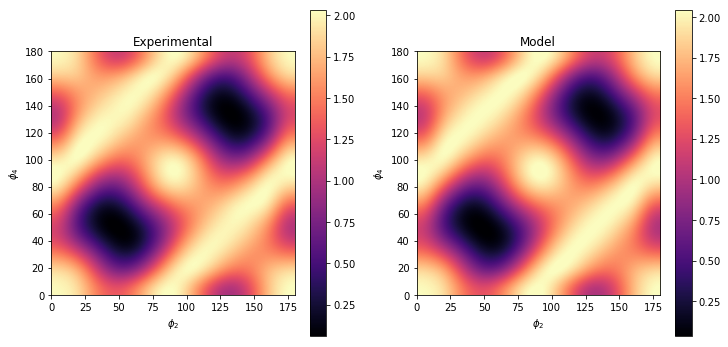

In [47]:
# Hacer el experimento
for ind1, angleDim1 in enumerate(angles2x):
    print("\n")
    for ind2, angleDim2 in enumerate(angles2y):
        pos = np.array([0, angleDim1, angleDim2, 0])
        delay = [0, 0, 0, 90]
        motors.move(
            positions = pos - theta0, velocities=Vels, kind='absolute',  verbose=False)
        intensities_2[ind1, ind2, :] = get_two_intensities(AIN_signal, AIN_ref, u=u3, d=d, verbose=True)
        Imodel2[ind1, ind2] = Intensity_Rotating_Elements(Mpol, pos*degrees, Ei=Ifuente)
intensity2 = intensities_2 - intensity_0
intensity2 = intensity2[:,:,0] * intensity2[:,:,1] / pol_dict["normal"]
# Plot results, 2D
plt.figure(figsize=(12, 6))   
plt.subplot(1,2,1)
plot_2d(angles2x, angles2y, intensity2, title='Experimental', xy_are_angles=False)
plt.subplot(1,2,2)
print(Imodel2.shape)
plot_2d(angles2x, angles2y, Imodel2, title='Model', xy_are_angles=False)